In [194]:
%matplotlib inline

from collections import defaultdict
from itertools import product
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [222]:
LOGS_DIR = Path('../logs/layers/')

HOST = '192.168.1.7'
PORT = '6006'

BASE_URL = f'http://{HOST}:{PORT}'
TEMPLATE_URL = BASE_URL + '/data/plugin/scalars/scalars?experiment=&run={}&tag={}&format=csv'

In [223]:
log_subdirs = sorted([d.name for d in LOGS_DIR.iterdir()])
log_subdirs

['batch_64-cell_LSTMCell-units_128-layers_1-ts_1542825068',
 'batch_64-cell_LSTMCell-units_128-layers_2-ts_1542825249',
 'batch_64-cell_LSTMCell-units_128-layers_3-ts_1542825556']

In [224]:
def tensorboard_to_df(run, tag, scale_time=True):
    df = pd.read_csv(TEMPLATE_URL.format(run, tag))
    if scale_time:
        df['Wall time'] -= df['Wall time'][0]
    return df

def join_paths(path, subpath):
    return f'{path}/{subpath}'

def get_dataframes(log_subdirs, run_subdirs, tags):
    df_dict = defaultdict(lambda: dict())
    
    for base_log, subdir, tag in product(log_subdirs, run_subdirs, tags):
        run = join_paths(base_log, subdir)
        subdir_tag = join_paths(subdir, tag)
        
        df_dict[base_log][subdir_tag] = tensorboard_to_df(run, tag)
        
    return df_dict

### Usage

In [225]:
run_subdirs = ['train', 'val']
tags = ['Accuracy_1', 'Loss']

dfs = get_dataframes(log_subdirs, run_subdirs, tags)

In [226]:
dfs.keys()

dict_keys(['batch_64-cell_LSTMCell-units_128-layers_1-ts_1542825068', 'batch_64-cell_LSTMCell-units_128-layers_2-ts_1542825249', 'batch_64-cell_LSTMCell-units_128-layers_3-ts_1542825556'])

In [227]:
dfs[list(dfs.keys())[0]].keys()

dict_keys(['train/Accuracy_1', 'train/Loss', 'val/Accuracy_1', 'val/Loss'])

In [228]:
dfs[log_subdirs[0]][join_paths('train', 'Loss')].head()

Wall time  Step     Value
0   0.000000     0  0.688204
1   2.668891   100  0.502706
2   5.083092   200  0.397148
3   7.493236   300  0.343582
4   9.171616   367  0.331676

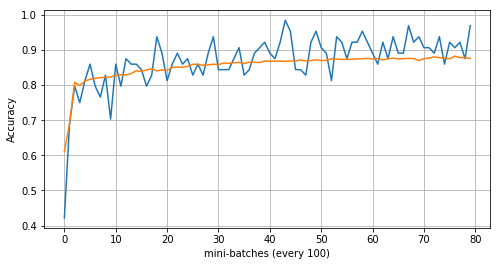

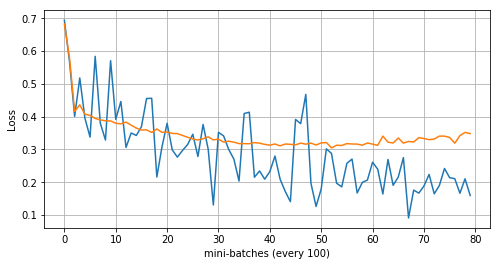

In [240]:
def plot_tensorboard_df(df, run_subdirs, tags, figsize=(8, 4), labels=None): 
    for i, tag in enumerate(tags):
        f, ax = plt.subplots(figsize=figsize)
        
        for base in run_subdirs:
            tag_df = df[join_paths(base, tag)]
            ax.plot(tag_df['Value'])
            
            name = labels[i] if labels else tag
            ax.set_ylabel(name)
            ax.set_xlabel('mini-batches (every 100)')
            ax.grid(True)

            f.savefig(f'images/{name}.pdf', bbox_inches='tight')

plot_tensorboard_df(dfs[log_subdirs[1]], run_subdirs, tags, labels=['Accuracy', 'Loss'])

In [203]:
def get_df_stats(df, run_subdirs, tags):
    names = [join_paths(base, tag) for base, tag in product(run_subdirs, tags)]
    bests = [round(df[name]['Value'].max(), 3) for name in names]
    return names, bests

get_df_stats(dfs[log_subdirs[0]], run_subdirs, tags)

(['train/Accuracy_1', 'train/Loss', 'val/Accuracy_1', 'val/Loss'],
 [0.969, 0.688, 0.877, 0.683])

In [213]:
data = []
for log_dir in log_subdirs:
    _, bests = get_df_stats(dfs[log_dir], run_subdirs, tags)
    data.append(bests)
    
export_df = pd.DataFrame(data, columns=['tr. accuracy', 'tr. loss', 'test accuracy', 'test loss'], index=log_subdirs) \
                        .reset_index().rename({'index': 'run'}, axis='columns')
export_df

run  tr. accuracy  tr. loss  \
0  batch_64-cell_LSTMCell-units_128-layers_1-ts_1...         0.969     0.688   
1  batch_64-cell_LSTMCell-units_128-layers_2-ts_1...         0.984     0.694   
2  batch_64-cell_LSTMCell-units_128-layers_3-ts_1...         0.984     0.692   

   test accuracy  test loss  
0          0.877      0.683  
1          0.882      0.682  
2          0.881      0.680

### Searching in dataframe

In [205]:
def filter_df_by_run(df, phrase):
    return df[df.run.str.contains(phrase)]

In [206]:
phrase = '256'
filter_df_by_run(export_df, phrase)

Empty DataFrame
Columns: [run, tr. accuracy, tr. loss, test accuracy, test loss]
Index: []

In [207]:
export_df

run  tr. accuracy  tr. loss  \
0  batch_64-cell_LSTMCell-units_128-layers_1-ts_1...         0.969     0.688   
1  batch_64-cell_LSTMCell-units_128-layers_2-ts_1...         0.984     0.694   
2  batch_64-cell_LSTMCell-units_128-layers_3-ts_1...         0.984     0.692   

   test accuracy  test loss  
0          0.877      0.683  
1          0.882      0.682  
2          0.881      0.680

In [216]:
import re

def get_first_group(comp_regexp, text):
    m = comp_regexp.search(text)
    return int(m.group(1)) if m else text

def rename_runs_by_regexp(df, regexp):
    r = re.compile(regexp)
    return df.run.map(lambda run: get_first_group(r, run))
    
regexp = 'layers_([0-9]+)'

export_df.run = rename_runs_by_regexp(export_df, regexp)

In [217]:
export_df.sort_values('run', inplace=True)
export_df

run  tr. accuracy  tr. loss  test accuracy  test loss
0    1         0.969     0.688          0.877      0.683
1    2         0.984     0.694          0.882      0.682
2    3         0.984     0.692          0.881      0.680

In [218]:
print(export_df.to_latex(index=False))

\begin{tabular}{rrrrr}
\toprule
 run &  tr. accuracy &  tr. loss &  test accuracy &  test loss \\
\midrule
   1 &         0.969 &     0.688 &          0.877 &      0.683 \\
   2 &         0.984 &     0.694 &          0.882 &      0.682 \\
   3 &         0.984 &     0.692 &          0.881 &      0.680 \\
\bottomrule
\end{tabular}



In [219]:
cols = ['tr. accuracy', 'test accuracy']
melted_df = pd.melt(export_df[['run', *cols]], id_vars="run", var_name="Type", value_name="Accuracy")
melted_df

run           Type  Accuracy
0    1   tr. accuracy     0.969
1    2   tr. accuracy     0.984
2    3   tr. accuracy     0.984
3    1  test accuracy     0.877
4    2  test accuracy     0.882
5    3  test accuracy     0.881

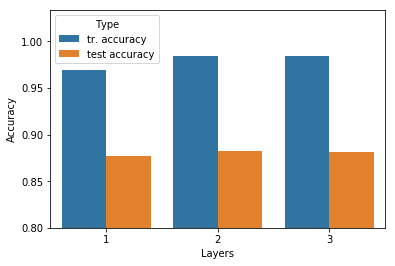

In [221]:
f = plt.figure()

ax = sns.barplot(data=melted_df, y='Accuracy', x='run', hue='Type')
ax.set_ybound(lower=.8)
ax.set_xlabel('Layers')

f.savefig('images/layers.pdf', bbox_inches='tight')